In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Importing the dataset
df = pd.read_csv('bank-additional-full.csv', sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df = df.replace("unknown", np.NaN)
df = df.dropna()
df = df.drop("duration", axis=1)

In [4]:
df['default'] = df['default'].map( {'no':0, 'yes':1})
df['housing'] = df['housing'].map( {'no':0, 'yes':1})
df['loan'] = df['loan'].map( {'no':0, 'yes':1})
df['y'] = df['y'].map( {'no':0, 'yes':1})
print(df.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [5]:
categoryList = list(df.select_dtypes(include=['object']).columns)
## Create dummy variables for non numerical categorical variables
dummies = pd.get_dummies(df[categoryList], prefix= categoryList)
df.drop(categoryList, axis=1, inplace = True) ## Drop Non numerical categorical columns
df=pd.concat([df,dummies], axis =1 ) ## added encoded categorical columns
df.head()

,age,default,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,0,0,1,999,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,0,1,0
2,37,0,1,0,1,999,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,0,1,0
3,40,0,0,0,1,999,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,0,1,0
4,56,0,0,1,1,999,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,0,1,0
6,59,0,0,0,1,999,0,1.1,93.994,-36.4,...,0,0,0,1,0,0,0,0,1,0


In [6]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
#correlation
corr_matrix = df.corr().abs()
corrCols = corr_matrix.columns.tolist()
corr_array  = np.array(corr_matrix)

In [7]:
mapCorr = go.Heatmap(z = corr_array,
                   x = corrCols,
                   y = corrCols,
                   colorscale = 'Viridis',
                   colorbar   = dict(title = "Pearson Correlation coefficient",titleside = "right")
                  )

layout = go.Layout(dict(height  = 600,
                        width   = 650,
                        margin  = dict(r = 0 ,l = 150,t = 20,b = 150),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [mapCorr]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [8]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
# Drop features 
df = df.drop(df[to_drop], axis=1)
to_drop

['euribor3m',
 'nr.employed',
 'contact_telephone',
 'poutcome_nonexistent',
 'poutcome_success']

In [9]:
corr_matrix = df.corr().abs()
#Correlation with output variable
cor_target = abs(corr_matrix["y"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
relevant_features

pdays           0.327509
previous        0.228003
emp.var.rate    0.305365
y               1.000000
Name: y, dtype: float64

In [10]:
# uncomment this code if u want to do prediction these 3 predictors and 1 predictor
# df = df[["pdays", "previous", "emp.var.rate", "y"]]
# df

In [11]:
print(df['y'].value_counts())
print("\n")

0    26629
1     3859
Name: y, dtype: int64




# Upsampling Minority Data

In [12]:
from sklearn.utils import resample
df_majority = df[df.y==0]
df_minority=df[df.y==1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples = df['y'].value_counts()[0])
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
print(df_upsampled['y'].value_counts())
print("\n")

1    26629
0    26629
Name: y, dtype: int64




In [13]:
# df_upsampled.to_excel("BankdroppedNullEncodedUpsampled.xlsx")

In [14]:
X_upsampled = df_upsampled.drop('y', 1)
y_upsampled = df_upsampled['y']

X = df.drop('y', 1)
y = df['y']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size = 0.1,random_state = 0)

# Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
%%time
classifier = LogisticRegression(max_iter = 1000, solver='liblinear')
classifier.fit(X_train_upsampled, y_train_upsampled)
y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[6600 1411]
 [ 379  757]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8011
           1       0.35      0.67      0.46      1136

    accuracy                           0.80      9147
   macro avg       0.65      0.75      0.67      9147
weighted avg       0.87      0.80      0.83      9147

Wall time: 1.47 s


In [17]:
accuracies_lr= cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, cv = 10) 
accuracies_lr_mean=accuracies_lr.mean()*100
print("Mean Accuracy:Logistic Regression=",accuracies_lr_mean)

accuracies_lr_std=accuracies_lr.std()*100
print("Standard Deviation:Logistic Regression=",accuracies_lr_std)

mean_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, scoring="roc_auc", cv = 10).mean()
std_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, scoring="roc_auc", cv = 10).std()

print("Mean AUC ROC Score:",mean_roc_auc_score)
print("Std Dev AUC ROC Score:",std_roc_auc_score)

Mean Accuracy:Logistic Regression= 74.0653453474469
Standard Deviation:Logistic Regression= 0.7854998803747009
Mean AUC ROC Score: 0.7954852382690172
Std Dev AUC ROC Score: 0.006264298809834334


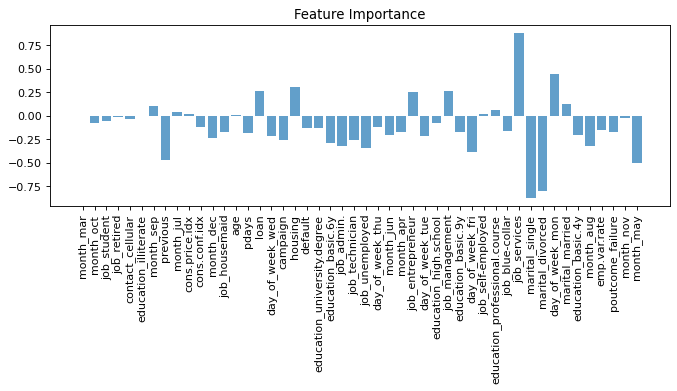

In [18]:
importance = classifier.coef_[0]
# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

indices = np.argsort(importance)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train_upsampled.columns[i] for i in indices]

from matplotlib.pyplot import figure
plt.figure(figsize=(10, 3), dpi=80, facecolor='w', edgecolor='k')

plt.title("Feature Importance")
plt.bar([x for x in range(len(importance))], importance, align='center', alpha=0.7)
# Add feature names as x-axis labels
plt.xticks([x for x in range(len(importance))], names, rotation=90)

plt.show()

# Backward elimination

In [19]:
import statsmodels.api as sm
cols = list(X_train_upsampled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_upsampled[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train_upsampled,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(len(selected_features_BE))
print(selected_features_BE)

45
['housing', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'contact_cellular', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure']


In [20]:
X_train_upsampled = X_train_upsampled[selected_features_BE]
X_test = X_test[selected_features_BE]

In [21]:
classifier = LogisticRegression(max_iter = 1000, solver='liblinear')
classifier.fit(X_train_upsampled, y_train_upsampled)
y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

accuracies_lr= cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, cv = 10) 
accuracies_lr_mean=accuracies_lr.mean()*100
print("Mean Accuracy:Logistic Regression=",accuracies_lr_mean)

accuracies_lr_std=accuracies_lr.std()*100
print("Standard Deviation:Logistic Regression=",accuracies_lr_std)

mean_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, scoring="roc_auc", cv = 10).mean()
std_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_upsampled, y = y_train_upsampled, scoring="roc_auc", cv = 10).std()

print("Mean AUC ROC Score:",mean_roc_auc_score)
print("Std Dev AUC ROC Score:",std_roc_auc_score)

[[6599 1412]
 [ 382  754]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8011
           1       0.35      0.66      0.46      1136

    accuracy                           0.80      9147
   macro avg       0.65      0.74      0.67      9147
weighted avg       0.87      0.80      0.83      9147

Mean Accuracy:Logistic Regression= 74.01944855786333
Standard Deviation:Logistic Regression= 0.7892352429132123
Mean AUC ROC Score: 0.7955578826022622
Std Dev AUC ROC Score: 0.006323202821455528


# Recursive feature elimination with cross-validation

Optimal number of features : 44


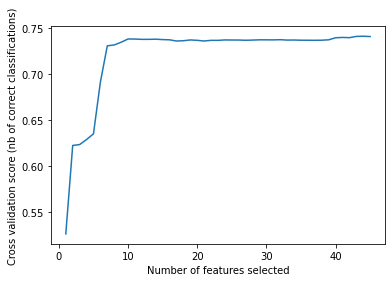

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
classifier = LogisticRegression(solver='liblinear')
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(5),scoring='accuracy')
rfecv.fit(X_train_upsampled,y_train_upsampled)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [23]:
df1= pd.DataFrame()
df1['feature'] = X_train_upsampled.columns
# df1['feature'] = X.columns
# print(df1['feature'])
df1['score']= rfecv.grid_scores_
# print(df1.sort_values(by='score', ascending=False))

In [24]:
df1 = df1.sort_values(by='score', ascending=False)
df1=df1[:rfecv.n_features_]
df1

,feature,score
43,day_of_week_wed,0.740862
42,day_of_week_tue,0.740674
44,poutcome_failure,0.740549
40,day_of_week_mon,0.739568
41,day_of_week_thu,0.739318
39,day_of_week_fri,0.739214
9,job_entrepreneur,0.737899
10,job_housemaid,0.737816
13,job_self-employed,0.737670
12,job_retired,0.737503


# Logistic Regression with reduced model

In [25]:
X_train_upsampled = X_train_upsampled[df1['feature']]
X_test = X_test[df1['feature']]

X_train_rLog = X_train_upsampled[df1['feature']]
X_test_rLog = X_test[df1['feature']]

classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train_rLog,y_train_upsampled)
y_pred=classifier.predict(X_test_rLog)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

from sklearn.model_selection import cross_val_score 

accuracies_lr= cross_val_score(estimator = classifier, X = X_train_rLog, y = y_train_upsampled, cv = 10) 
accuracies_lr_mean=accuracies_lr.mean()*100
print("Mean Accuracy:Logistic Regression=",accuracies_lr_mean)

accuracies_lr_std=accuracies_lr.std()*100
print("Standard Deviation:Logistic Regression=",accuracies_lr_std)

mean_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_rLog, y = y_train_upsampled, scoring="roc_auc", cv = 10).mean()
std_roc_auc_score = cross_val_score(estimator = classifier, X = X_train_rLog, y = y_train_upsampled, scoring="roc_auc", cv = 10).std()

print("Mean AUC ROC Score:",mean_roc_auc_score)
print("Std Dev AUC ROC Score:",std_roc_auc_score)

[[6594 1417]
 [ 381  755]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      8011
           1       0.35      0.66      0.46      1136

    accuracy                           0.80      9147
   macro avg       0.65      0.74      0.67      9147
weighted avg       0.87      0.80      0.83      9147

Mean Accuracy:Logistic Regression= 74.07160665137006
Standard Deviation:Logistic Regression= 0.7232970972700237
Mean AUC ROC Score: 0.7953809219596042
Std Dev AUC ROC Score: 0.006336736350826738


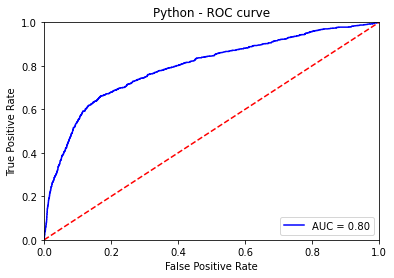

In [29]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier.predict_proba(X_test_rLog)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Python - ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Fit Logistic regression to test dataset

In [30]:
# Importing the dataset
df_test = pd.read_csv('bank-additional.csv', sep=";")
df_test.head()
# df_test.to_excel("bank-test-data.xlsx")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [31]:
df_test = df_test.replace("unknown", np.NaN)
df_test['default'] = df_test['default'].map( {'no':0, 'yes':1})
df_test['housing'] = df_test['housing'].map( {'no':0, 'yes':1})
df_test['loan'] = df_test['loan'].map( {'no':0, 'yes':1})
df_test['y'] = df_test['y'].map( {'no':0, 'yes':1})
df_test = df_test.dropna()
df_test = df_test.drop("duration", axis=1)
print(df_test.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [32]:
### Convert Non Numerical Categorical column into numeric ones
categoryList = list(df_test.select_dtypes(include=['object']).columns)

## Create dummy variables for non numerical categorical variables
dummies = pd.get_dummies(df_test[categoryList], prefix= categoryList)

df_test.drop(categoryList, axis=1, inplace = True) ## Drop Non numerical categorical columns

df_test=pd.concat([df_test,dummies], axis =1 ) ## added encoded categorical columns

# dropped highly correlated variables
df_test = df_test.drop(df_test[to_drop], axis=1)

X = df_test.drop(['y'], axis=1)
y = df_test.y
X = X[X_train_upsampled.columns]
X.head()

,day_of_week_wed,day_of_week_tue,poutcome_failure,day_of_week_mon,day_of_week_thu,day_of_week_fri,job_entrepreneur,job_housemaid,job_self-employed,job_retired,...,marital_single,job_technician,job_blue-collar,job_admin.,cons.conf.idx,cons.price.idx,emp.var.rate,previous,pdays,campaign
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,-46.2,92.893,-1.8,0,999,2
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,-36.4,93.994,1.1,0,999,4
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-41.8,94.465,1.4,0,999,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,-42.0,93.200,-0.1,0,999,1
5,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,-37.5,94.199,-1.1,2,999,3


In [33]:
kfold = KFold(n_splits=10)
result = cross_val_score(classifier, X, y, cv=kfold, scoring='accuracy')
print(result.mean())

0.8870550161812298


In [34]:
y_pred = classifier.predict(X)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[[2276  444]
 [ 131  239]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      2720
           1       0.35      0.65      0.45       370

    accuracy                           0.81      3090
   macro avg       0.65      0.74      0.67      3090
weighted avg       0.87      0.81      0.84      3090

